In [1]:
import pandas as pd

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
import scipy
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import pickle
from collections import Counter

import matplotlib.pyplot as plt

import sys

scripts_dir = '../scripts/'
sys.path.append(scripts_dir)
import IDseq_pathogen_functions2 
import IDSeq_plotting_functions_v2

%matplotlib inline

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
#training_sample_names = ["mBAL-212-RNA-TA","mBAL-225-RNA-TA","mBAL-298-RNA-TA","mBAL-304-RNA-TA",
#                         "mBAL-314-RNA-TA","mBAL-315-RNA-TA","mBAL-335-RNA-TA","mBAL-337-RNA-TA",
#                         "mBAL-343-RNA-TA","mBAL-350-RNA-TA","mBAL-349-RNA-TA","mBAL-273-RNA-TA",
#                         "mBAL-331-RNA-TA","mBAL-221-RNA-TA","mBAL-220-RNA-TA","mBAL-215-RNA-TA",
#                         "mBAL-270-RNA-TA","mBAL-241-RNA-TA","mBAL-211-RNA-TA","mBAL-218-RNA-TA"]

In [4]:
output_directory = '073118'

def sqrt_value(matrix):
    matrix['perc_NR2'] = np.sqrt(matrix['perc_NR2'])
    matrix['perc_NT2'] = np.sqrt(matrix['perc_NT2'])
    #return matrix
    
def round_rpm(matrix):
    X['log(NR_rpm)'] = np.round(X['log(NR_rpm)'])
    X['perc_NR2'] = np.round(X['perc_NR2']*10)
    X['perc_NT2'] = np.round(X['perc_NT2']*10)

In [27]:
# Parse out the relevant features from Figure S1 - generated in main analysis above.
X = pd.read_csv("./output/073018/microbe_data.csv", index_col = 0)

# look only at RNA-seq files (since this project contained both, this is an extra filtration step)
X = X[X['RNA'] == True]
#print("\n".join(list(X.columns)))

#sqrt_value(X)
#round_rpm(X)

---
{'model_parameters': ['log(genus_NR_rpm)', 'reference_pathogen', 'perc_NR2'], 'graph_axis': 'log(genus_NR_rpm)', 'label': 'LRTIstatus', 'positive_class': 'LRTI+C+M', 'negative_class': 'no-LRTI', 'unknown_class': ['LRTI+C', 'LRTI-unk'], 'training_set': ['mBAL-212-RNA-TA', 'mBAL-225-RNA-TA', 'mBAL-298-RNA-TA', 'mBAL-304-RNA-TA', 'mBAL-314-RNA-TA', 'mBAL-315-RNA-TA', 'mBAL-335-RNA-TA', 'mBAL-337-RNA-TA', 'mBAL-343-RNA-TA', 'mBAL-350-RNA-TA', 'mBAL-349-RNA-TA', 'mBAL-273-RNA-TA', 'mBAL-331-RNA-TA', 'mBAL-221-RNA-TA', 'mBAL-220-RNA-TA', 'mBAL-215-RNA-TA', 'mBAL-270-RNA-TA', 'mBAL-241-RNA-TA', 'mBAL-211-RNA-TA', 'mBAL-218-RNA-TA']}
LRTIstatus


In [ ]:
config_file = "./reference/config.txt"

def parse_params(config_file):
    configs = open(config_file, 'r').readlines()
    parameters = dict([(i.strip().split(':')[0],i.strip().split(':')[1].strip()) for i in configs])
    mp = parameters['model_parameters'].split(',')
    gp = parameters['plot_x']
    meta_class = parameters['label']
    positive_class = parameters['positive_class']
    negative_class = parameters['negative_class']
    unknown_class = parameters['unknown_class'].split(',')
    training_sample_names = parameters['training_set'].split(',')
    
    output_parameters = {
        'model_parameters':mp,
        'graph_axis':gp,
        'label':meta_class,
        'positive_class':positive_class,
        'negative_class':negative_class,
        'unknown_class':unknown_class,
        'training_set':training_sample_names
    }
    
    return(output_parameters)
    
parameters = parse_params(config_file)
print('---')
print(parameters)

print(parameters['label'])

In [26]:
# Separate out by group membership for training and analysis of True Positive / True Negative
X_g1 = X[X[parameters['label']] == parameters['positive_class']]
X_unk = pd.concat([X[X[parameters['label']] == i] for i in parameters['unknown_class']])

#X_g2 = X[X[parameters['label']] == 'LRTI+C']
#X_g3 = X[X[parameters['label']] == 'LRTI-unk']
X_g4 = X[X[parameters['label']] == parameters['negative_class']]
#X_g1g4 = pd.concat([X_g1, X_g4], axis=0)

X_g1g4_train = X_g1g4[X_g1g4['sampleID'].isin(parameters['training_set'])] 
X_g1g4_test = X_g1g4[~X_g1g4['sampleID'].isin(parameters['training_set'])] 

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_g1 = X_g1['positive'].tolist()
Y_g2 = X_g2['positive'].tolist()
Y_g3 = X_g3['positive'].tolist()
Y_g4 = X_g4['positive'].tolist()
Y_g1g4 = X_g1g4['positive'].tolist()

sklearn version:
0.18.1


-----

Output metrics (at threshold = 0.2)
Logistic regression Train AUC for 1000 rounds CV ::  0.9650465741591311
Logistic regression Test AUC for 1000 rounds CV ::  0.9130094298167011


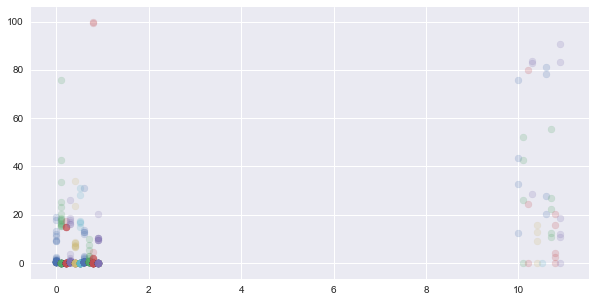

In [28]:
# 1000 rounds of cross-validation of LRM
print("sklearn version:")
print(sklearn.__version__)

training_variables = parameters['model_parameters'] #['log(NR_rpm)','reference_pathogen','perc_NR2']#,]   ,'perc_NT2','log(NT_rpm)',,'perc_NT2'
PROBABILITY_THRESHOLD = .2

many_rounds_train_auc = []
many_rounds_test_auc = []
tprs_iterative = []
aucs_iterative = []
mean_fpr_iterative = np.linspace(0, 1, 100)

# set up training data
X_pos = X_g1g4_train[X_g1g4_train['positive'] == True]
X_neg = X_g1g4_train[X_g1g4_train['positive'] == False]
X_combo = X_g1g4_train #pd.concat([X_g1_train,X_g4_train])  # train on both group 1 and group 4 patients
y_combo = list(X_combo['positive'])

# track num iterations w/ 1 class (likely the negative class) in the test set
oneclasspresent = 0    
c = ['blue','red']

plt.figure(figsize=[10,5])

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X_combo[training_variables], y_combo, test_size=0.3
    ) 
    
    try:
        lr = linear_model.LogisticRegression(C=1000000)
        lr.fit(X_train, y_train)
        
        many_rounds_train_auc.append(
            metrics.roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
        many_rounds_test_auc.append(
            metrics.roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
            
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test, lr.predict_proba(X_test)[:,1], pos_label=1)  
        tprs_iterative.append(interp(mean_fpr_iterative, fpr, tpr))
        tprs_iterative[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs_iterative.append(roc_auc)
        if i < 10:
            plt.scatter([int(j)*10 + .1 * i for j in y_test] , lr.predict_proba(X_test)[:,1] * 100, alpha = .2)
        
    except Exception as e:
        # if only 1 class is present, cannot compute the req'd stats; skip this iteration
        oneclasspresent += 1    

print("\nWARNING: only one class was present in the test set for " + str(oneclasspresent) +
      " rounds of train/test split")
print("\n-----\n\nOutput metrics (at threshold = " + str(PROBABILITY_THRESHOLD) + ")")
print("Logistic regression Train AUC for 1000 rounds CV :: ", np.mean(many_rounds_train_auc))
print("Logistic regression Test AUC for 1000 rounds CV :: ", np.mean(many_rounds_test_auc))

In [8]:
# LOPO-CV schematic is as follows:
# IN EACH ITERATION...
#  1. Remove all microbes from one sampleID
#  2. Train on microbes from all other sampleIDs
#  3. Predict for all microbes in the held-out sampleID
# This results in the predicted [pathogen v. commensal] probability for each microbe 
# in the training set

#
# RUN LOPO-CV ON ALL GROUP 1 AND GROUP 4 PATIENTS
#

# full training data
Y_g1g4_train = X_g1g4_train[['positive']]

sampleIDs_to_remove = list(set(X_g1g4_train['sampleID']))  # names of each sampleID in the training set
predictions = []
truths = []
training_auc = []
c = ['blue','red']
sampleID_max_scores = {}
sampleID_groups = {}

for i in sampleIDs_to_remove:  # loop through all sampleIDs
    
    # training set is all g1g4_train microbes that are not from sampleID = i
    X_train_sub = X_g1g4_train[X_g1g4_train['sampleID'] != i]   
    X_train = X_train_sub[training_variables] 
    y_train = X_train_sub['positive']

    # test set is all g1g4_train microbes that are from sampleID = i
    X_test_sub = X_g1g4_train[X_g1g4_train['sampleID'] == i]   
    X_test = X_test_sub[training_variables] 
    y_test = X_test_sub['positive']

    lr = linear_model.LogisticRegression(C=1000000) # large C, effectively no regularization
    lr.fit(X_train, y_train)                        # fit the logistic regression model
    p_test = lr.predict_proba(X_test)[:,1]          # predict on the left-out sub test set
    p_train = lr.predict_proba(X_train)[:,1]        # predict on the training set 
    
    # METRICS for evaluating model performance
    # append subset predictions to list of all predictions
    predictions = predictions + list(p_test)
    # append truth values to list of all true classifications
    truths = truths + list(y_test)
    # calculate AUC for training subset
    training_auc.append(metrics.roc_auc_score([int(j) for j in y_train], p_train))  
        
    # track the maximum pathogen v. commensal score per sampleID
    sampleID_max_scores[i] = max(list(p_test))  
    sampleID_groups[i] = list(X_test_sub['LRTIstatus'])[0]   # track the LRTI group
        
    count = 0
    
    # append the pathogen v. commensal LRM "score" value to each row of the X_g1g4_train matrix ...
    # ... for downstream plots 
    for j in X_g1g4_train[X_g1g4_train['sampleID'] == i].index:  
        X_g1g4_train.loc[j,'score'] = p_test[count]
        count += 1
        
print("Mean AUC for LOPO-CV training: " + str(np.mean(training_auc)))  
print("\nTotal AUC for LOPO-CV predictions: " + str(metrics.roc_auc_score([int(i) for 
                                                                           i in truths], 
                                                                          predictions)))
IDseq_pathogen_functions2.get_CI([int(i) for i in truths], predictions, 1000);

# Youden's index for pathogen v. commensal model 
# We are not using this in the analysis for consistency in threshold btwn pathogen v. 
# commensal and LRTI v. no-LRTI models
# youdens_patho_commensal_model = IDseq_pathogen_functions2.Find_Optimal_Cutoff([int(i) for i in truths], predictions)
# print("Youden's training pathogen v. commensal: " + str(youdens_patho_commensal_model))

Mean AUC for LOPO-CV training: 0.9673363132113876

Total AUC for LOPO-CV predictions: 0.8907563025210085
Original ROC area: 0.891, [0.749 - 0.984]


['LRTI+C+M', 'LRTI+C+M', 'LRTI+C+M', 'no-LRTI', 'no-LRTI', 'no-LRTI', 'no-LRTI', 'LRTI+C+M', 'no-LRTI', 'LRTI+C+M', 'no-LRTI', 'no-LRTI', 'no-LRTI', 'no-LRTI', 'LRTI+C+M', 'LRTI+C+M', 'LRTI+C+M', 'LRTI+C+M', 'LRTI+C+M']
[0.1662745676422382, 0.8729753794581111, 0.9029891093851713, 0.017654877710958805, 0.1426513810648822, 0.14417372479191534, 0.040832235803086, 0.884986810960723, 0.046080565203068836, 0.1291261590349174, 0.26358104907961727, 0.0401024519286617, 0.035966240964935586, 0.23785221500262996, 0.3586306700682968, 0.7750072473954461, 0.5856426079322968, 0.8196031522676787, 0.4090408124445523]
19
19
AUC for distinguishing LRTI+C+M v. no-LRTI sampleIDs (train)= 0.9333333333333333


No handles with labels found to put in legend.


Original ROC area: 0.933, [0.833 - 1.0]

At probability threshold = 0.2
TP, FP, TN, FN
(8, 2, 7, 2)


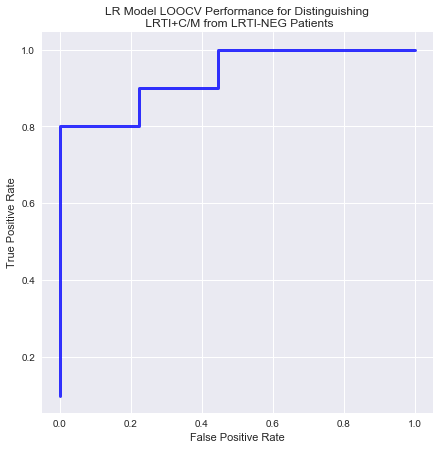

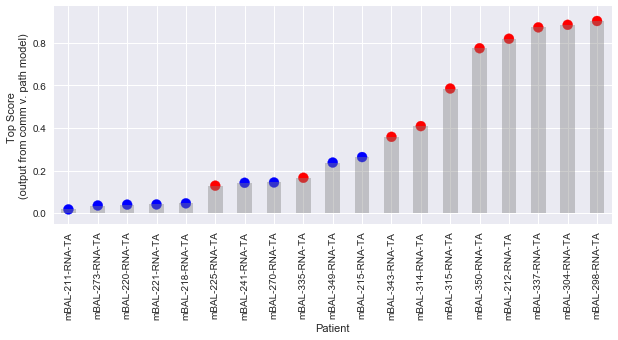

mBAL-211-RNA-TA    0.017655
mBAL-273-RNA-TA    0.035966
mBAL-220-RNA-TA    0.040102
mBAL-221-RNA-TA    0.040832
mBAL-218-RNA-TA    0.046081
mBAL-225-RNA-TA    0.129126
mBAL-241-RNA-TA    0.142651
mBAL-270-RNA-TA    0.144174
mBAL-335-RNA-TA    0.166275
mBAL-349-RNA-TA    0.237852
mBAL-215-RNA-TA    0.263581
mBAL-343-RNA-TA    0.358631
mBAL-314-RNA-TA    0.409041
mBAL-315-RNA-TA    0.585643
mBAL-350-RNA-TA    0.775007
mBAL-212-RNA-TA    0.819603
mBAL-337-RNA-TA    0.872975
mBAL-304-RNA-TA    0.884987
mBAL-298-RNA-TA    0.902989
Name: 0, dtype: float64
P-value for top microbe score in LRTI+C/M versus LRTI-NEG: 0.0014508616333606355


In [9]:
# USE THE PATIENT-SPECIFIC MAX SCORE VALUE TO CREATE A CLASSIFIER FOR G1 V. G4 PATIENTS...
# actually, we only have 1 feature so we will just evaluate the AUC.

scores = []
group = []
sampleID_names = []
for i in sampleID_max_scores.keys():
    scores.append(sampleID_max_scores[i])
    group.append(sampleID_groups[i])
    sampleID_names.append(i)

print(group)
print(scores)
print(len(group))
print(len(scores))
    
# Generate AUC curve for predicting Group 1 v. Group 4 from the top microbe score
#youdens_sampleID_microbe_model = IDseq_pathogen_functions2.Find_Optimal_Cutoff(group, scores)
#print("Youden's training sampleID microbe: " + str(youdens_sampleID_microbe_model))
fpr, tpr, thresholds = metrics.roc_curve(group, scores, pos_label='LRTI+C+M')  
print("AUC for distinguishing LRTI+C+M v. no-LRTI sampleIDs (train)= " + 
      str(metrics.roc_auc_score([int(i=='LRTI+C+M') for i in group], scores)))
IDseq_pathogen_functions2.get_CI([int(i=='LRTI+C+M') for i in group], scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(IDseq_pathogen_functions2.perf_measure([i > PROBABILITY_THRESHOLD for i in scores], 
                                      [int(i=='LRTI+C+M') for i in group]))


# PLOT: Figure S3
# AUC curve for LRTI+C+M v. no-LRTI using the max. pathogen v. commensal probability per sampleID
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b', lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model LOOCV Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2.pdf')
plt.show()

# PLOT: max predicted probability score by sampleID - for visualization and 
# double-checking feasability of AUC
plt.ylabel("Top Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(sampleID_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 'LRTI+C+M') for i in group]
df.sort_values(by=0,inplace=True)
df[0].plot(kind='bar',color='grey',figsize=(10,4), alpha=.4)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
plt.show()
print(df[0])  # print out the sampleID ID and max microbe score (same as plot)


# evaluate the p-value of scores from group 1 and group 4
group1_scores = []
group4_scores = []
for i in range(len(group)):
    if int(group[i] =='LRTI+C+M'):
        group1_scores.append(scores[i])
    else:
        group4_scores.append(scores[i])

print("P-value for top microbe score in LRTI+C/M versus LRTI-NEG: " + 
      str(scipy.stats.ranksums(group1_scores,group4_scores).pvalue))

# Create the data for per-sampleID heatmap view showing all microbes that passed 
# the threshold for all sampleIDs (in groups 1 and group 4)
creating_matrix_from_Xg1g4_train = X_g1g4_train[X_g1g4_train['score'] > PROBABILITY_THRESHOLD]
sampleID_by_microbe_predicted_g1g4_train = creating_matrix_from_Xg1g4_train[['name',
                                                                  'sampleID',
                                                                  'genus_name']]
sampleID_by_microbe_predicted_g1g4_train.index = [i for i in range(len(
    sampleID_by_microbe_predicted_g1g4_train.index))]


LRM Model Coefficients for final pathogen v. commensal trained model:
['log(genus_NR_rpm)', 'reference_pathogen', 'perc_NR2']
[[0.26599717 3.99636564 3.56413414]]

 # of Pathogens v. Commensals in Training and Test sets, respectively:
Counter({False: 238, True: 12})
Counter({False: 305, True: 22})


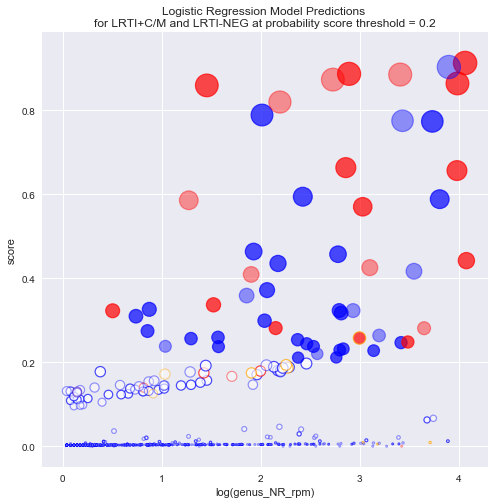

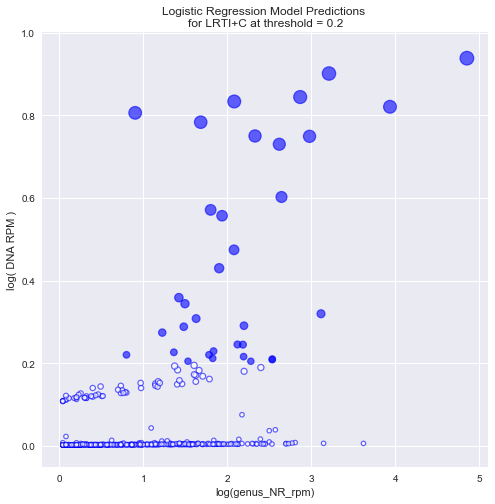

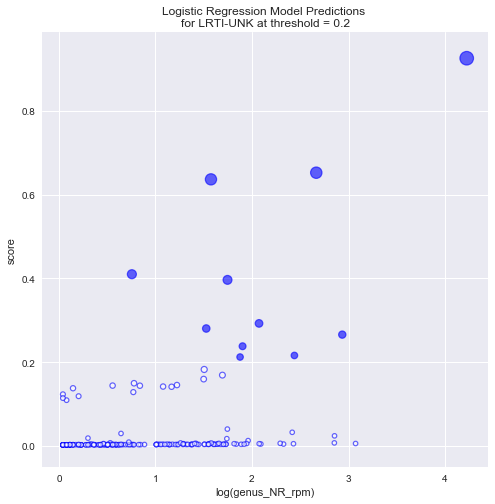

In [11]:
annotate_plots = False


# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

# create fresh linear model; large C to run non-regularized regression
lr = linear_model.LogisticRegression(C=1000000)

# Train on all Group 1 and Group 4 sampleIDs
lr = lr.fit(X_g1g4_train[training_variables],Y_g1g4_train)

print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)

# save the combined model to a pickle file 
pickle.dump(lr, open('./output/' + output_directory + '/mBAL_g1g4combo_logRegModel', 'wb'))  

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
                   
# establish the test set
#X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1g4_test = list(X_g1g4_test['positive'])

Y_g1g4_train = list(X_g1g4_train['positive'])

print("\n # of Pathogens v. Commensals in Training and Test sets, respectively:")
print(Counter(Y_g1g4_train))
print(Counter(Y_g1g4_test))

# Plot predicted probabilities for group 1 TEST SET sampleIDs' microbes
predicted = lr.predict_proba(X_g1g4_test[training_variables])
X_g1g4_test['score'] = predicted[:,1]  # append the predicted probabilities to the data matrix

# PLOT: RNA v. DNA plot with microbes shown with probabilities.
plt.figure(figsize=[8,8])

# visualize the test set in RNA rM by DNA rM space;
plt.scatter(X_g1g4_test[graph_axis],
            X_g1g4_test['score'],
            edgecolor=[c[int(X_g1g4_test.loc[i]['positive'])] 
                       if X_g1g4_test[X_g1g4_test['sampleID'] == 
                                      X_g1g4_test.loc[i]['sampleID']]['positive'].sum() < 2 
                       or c[int(X_g1g4_test.loc[i]['positive'])] == 'blue' 
                       or X_g1g4_test.loc[i]['score'] == max(
                           X_g1g4_test[(X_g1g4_test.sampleID == X_g1g4_test.loc[i]['sampleID']) 
                                       & (X_g1g4_test.positive == True)]['score']) 
                       else 'orange' for i in X_g1g4_test.index],
            s=[max(i*600,3) for i in X_g1g4_test['score']],
            facecolor=[c[int(Y_g1g4_test[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g1g4_test)) ],
            alpha=.7, linewidth=1.2) 

# add the scatterplot of predicted TRAINING microbes in RNA rM by DNA rM space;
plt.scatter(X_g1g4_train[graph_axis],
            X_g1g4_train['score'],
            edgecolor=[c[int(X_g1g4_train.loc[i]['positive'])] 
                       if X_g1g4_train[X_g1g4_train['sampleID'] == 
                                  X_g1g4_train.loc[i]['sampleID']]['positive'].sum() < 2 
                       or c[int(X_g1g4_train.loc[i]['positive'])] == 'blue' 
                       or X_g1g4_train.loc[i]['score'] == max(
                           X_g1g4_train[(X_g1g4_train.sampleID == X_g1g4_train.loc[i]['sampleID'])
                                   & (X_g1g4_train.positive == True)]['score']) 
                       else 'orange' for i in X_g1g4_train.index],
            s=[max(i*600,3) for i in X_g1g4_train['score']],
            facecolor=[c[int(X_g1g4_train.iloc[i]['positive'])] if X_g1g4_train.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_g1g4_train['positive'])) ],
            alpha=.4, linewidth=1.2) 

plt.title(
    "Logistic Regression Model Predictions \nfor LRTI+C/M and LRTI-NEG at probability score threshold = " + 
    str(PROBABILITY_THRESHOLD))
plt.xlabel(graph_axis)
plt.ylabel("score")
plt.savefig('./output/' + output_directory + '/Figure2D.pdf')

plt.show()


print("\n\n")

#
# Predictions for Group 2 (LRTI+C) and Group 3 (unk-LRTI) sampleIDs
#

# LRTI+C PREDICTIONS

annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 sampleIDs' microbes
predicted = lr.predict_proba(X_g2[training_variables])
# append the group 2 pathogen v. commensal model to the original data matrix
X_g2['score'] = predicted[:,1]

plt.figure(figsize=[8,8])
plt.scatter(X_g2[graph_axis],X_g2['score'],
            edgecolor=[c[int(i)] for i in Y_g2],
            s=[max(i*200,20) for i in predicted[:,1]],
            facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g2)) ],
            alpha=.6, linewidth=1.2)  

plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel(graph_axis)
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')


# unk-LRTI PREDICTIONS
predicted = lr.predict_proba(X_g3[training_variables]) 
X_g3['score'] = predicted[:,1]
plt.figure(figsize=[8,8])
plt.scatter(X_g3[graph_axis],X_g3['score'],
            edgecolor=[c[int(i)] for i in Y_g3],
            s=[max(i*200,20) for i in predicted[:,1]],
            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_g3)) ],
            alpha=.6, linewidth=1.2) 

plt.title("Logistic Regression Model Predictions \nfor LRTI-UNK at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel(graph_axis)
plt.ylabel('score')
plt.savefig('./output/' + output_directory + '/FigureS3D.pdf')



TRAINING RESULTS

TEST RESULTS

GROUP 2 RESULTS

GROUP 3 RESULTS


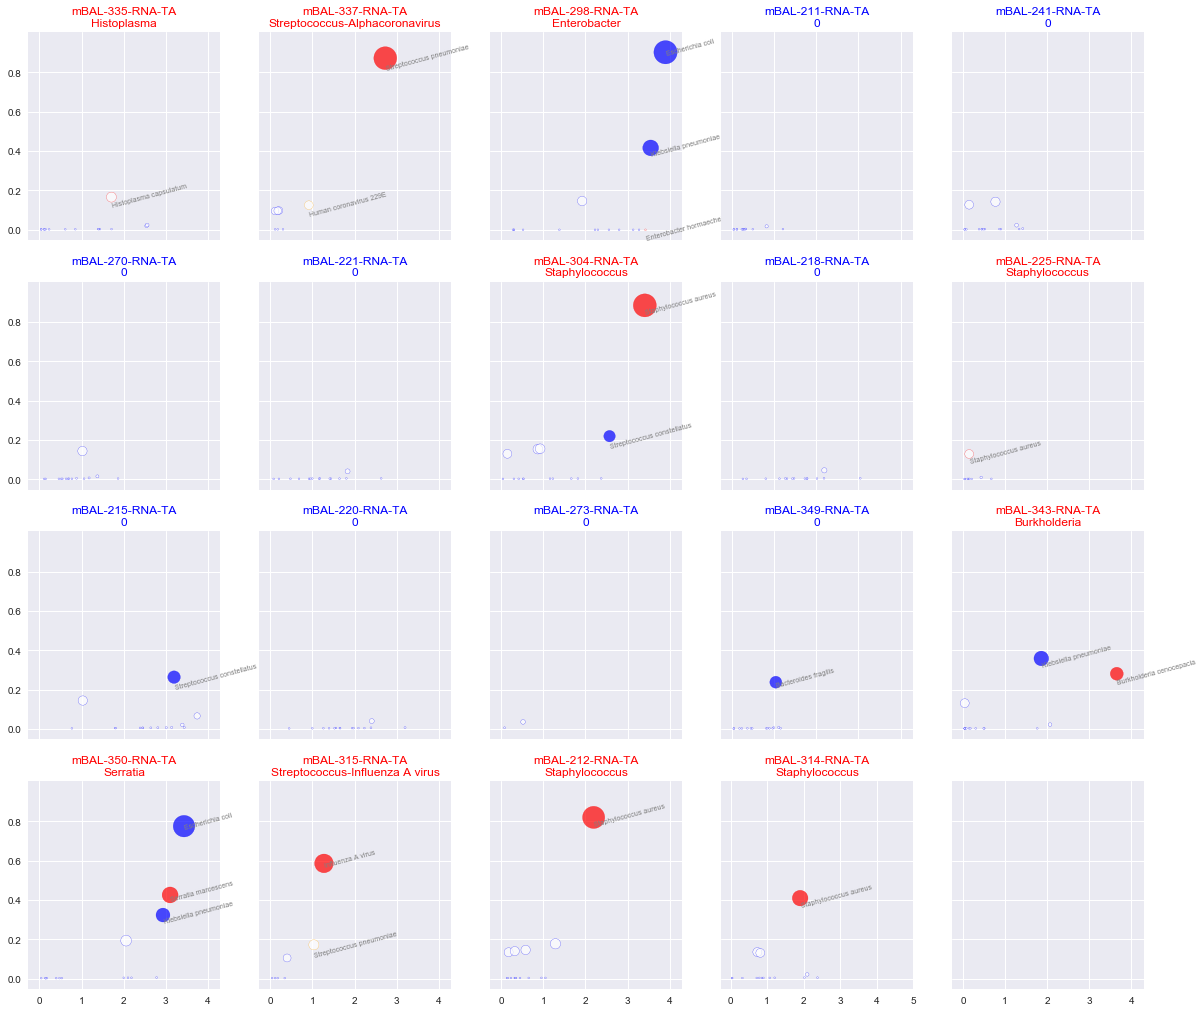

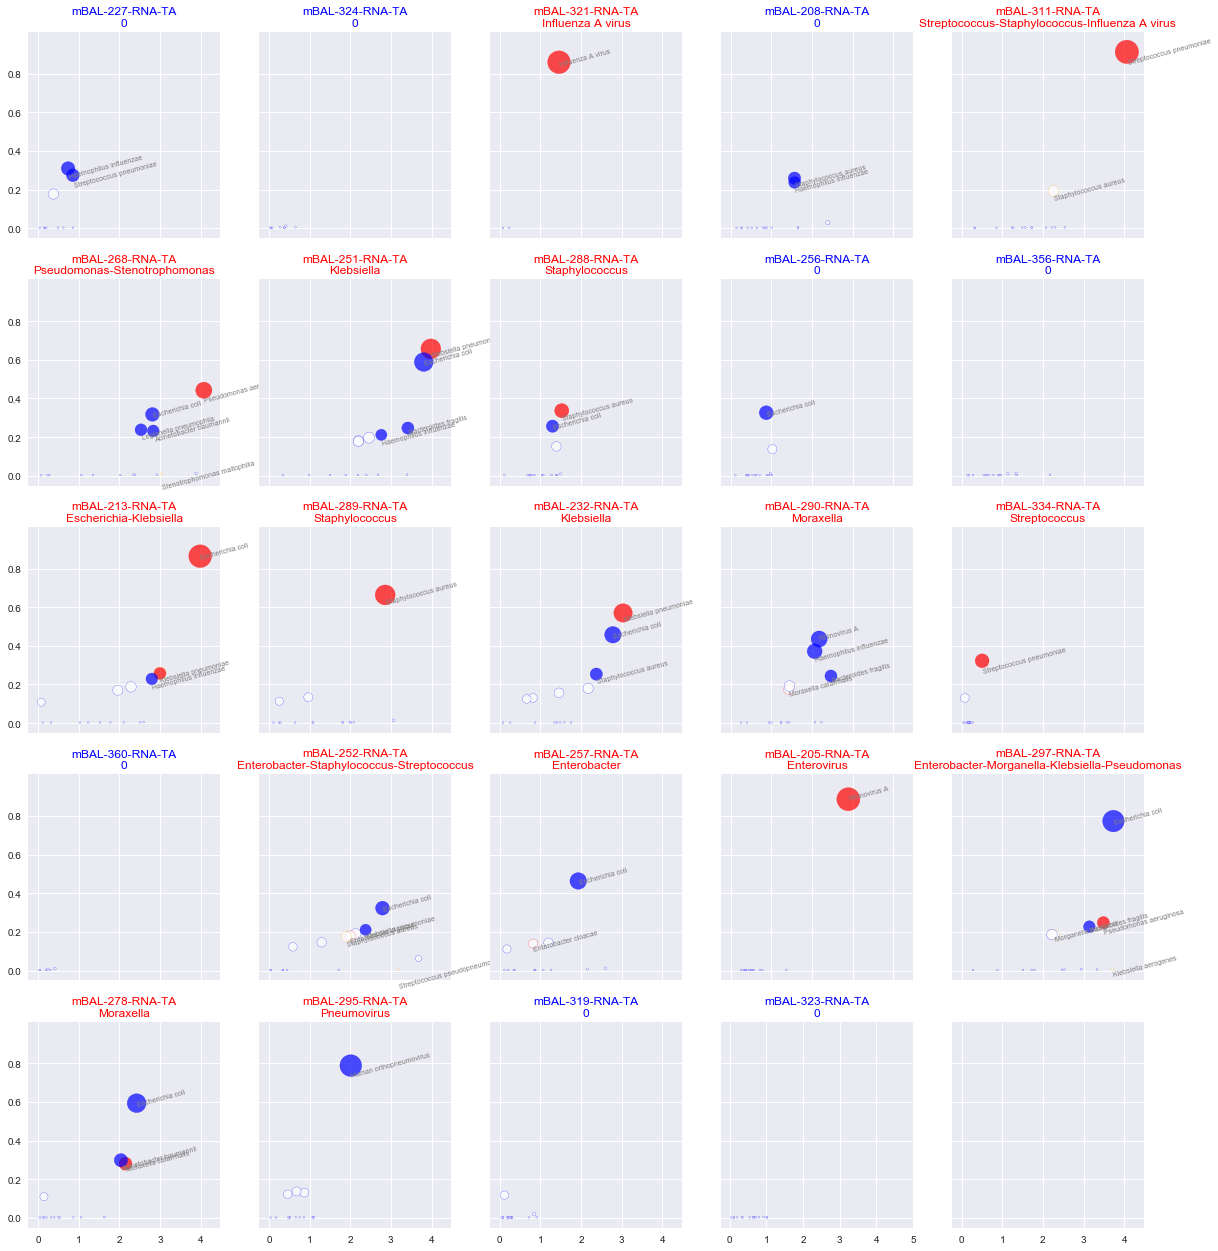

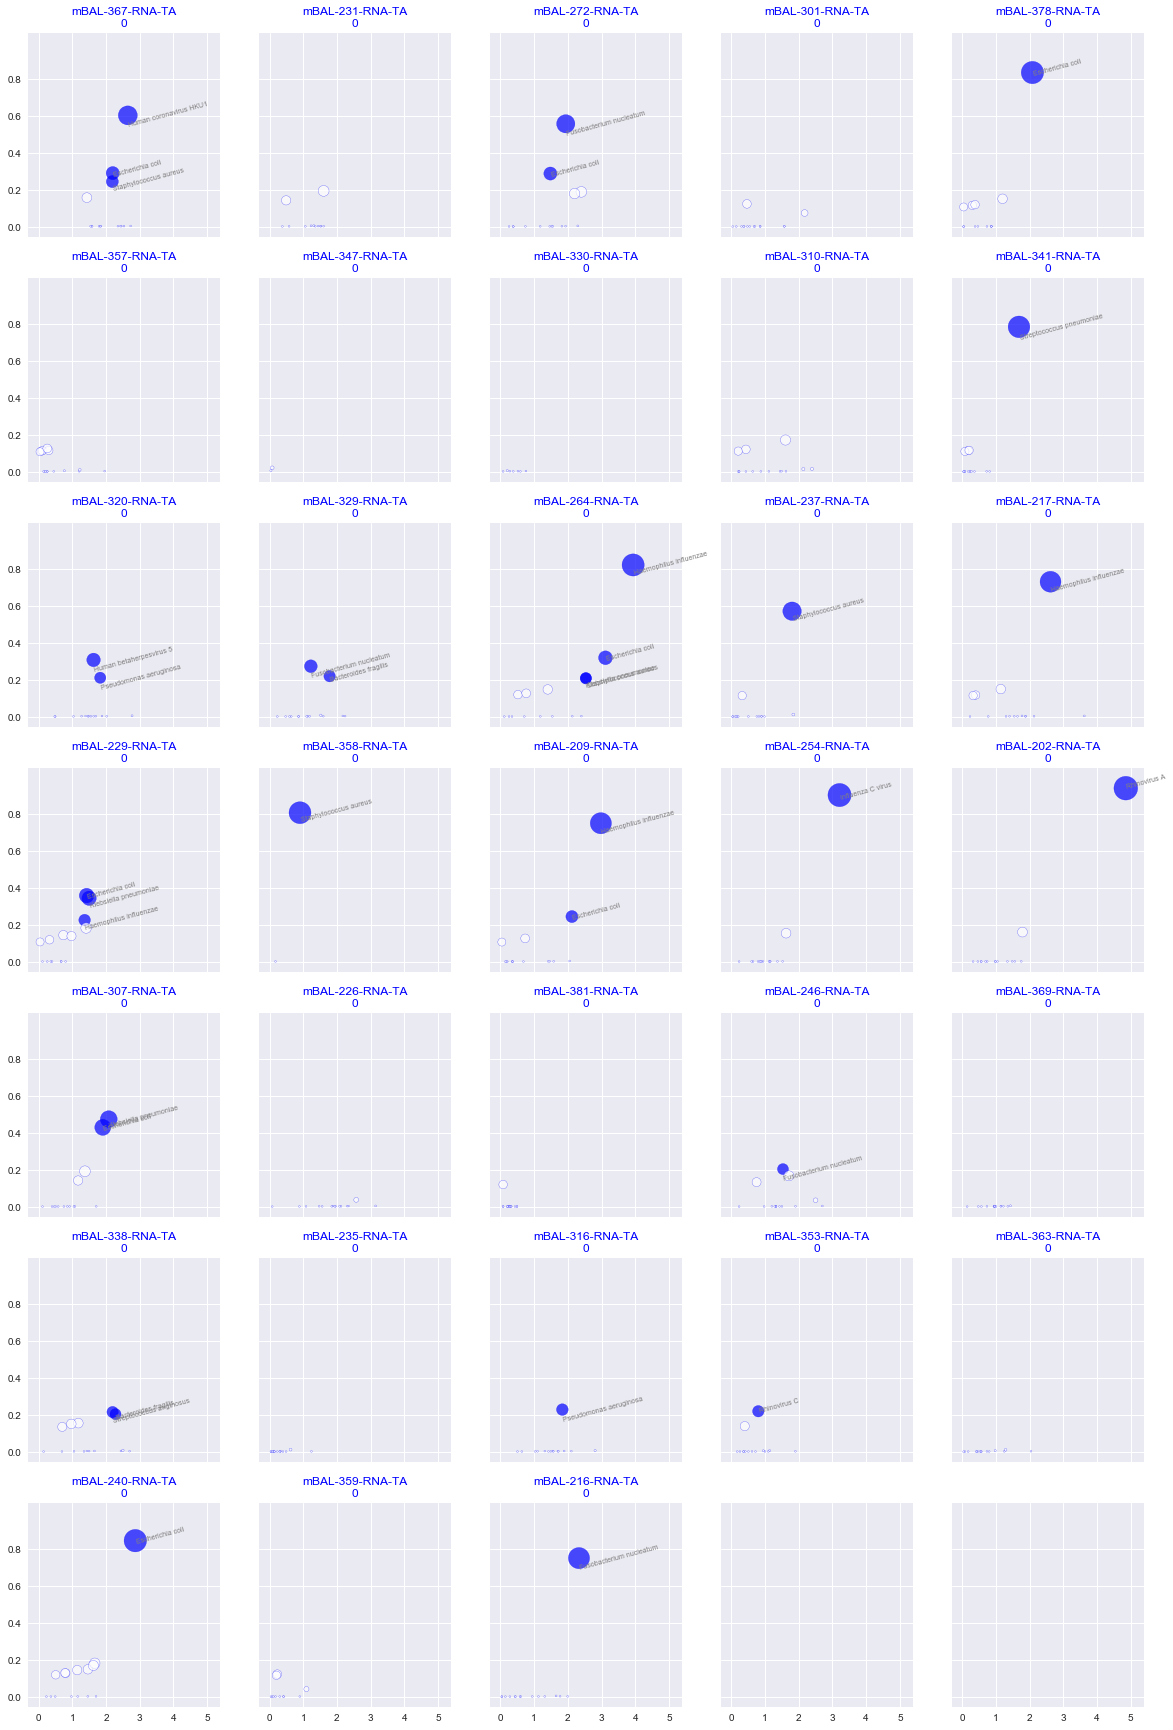

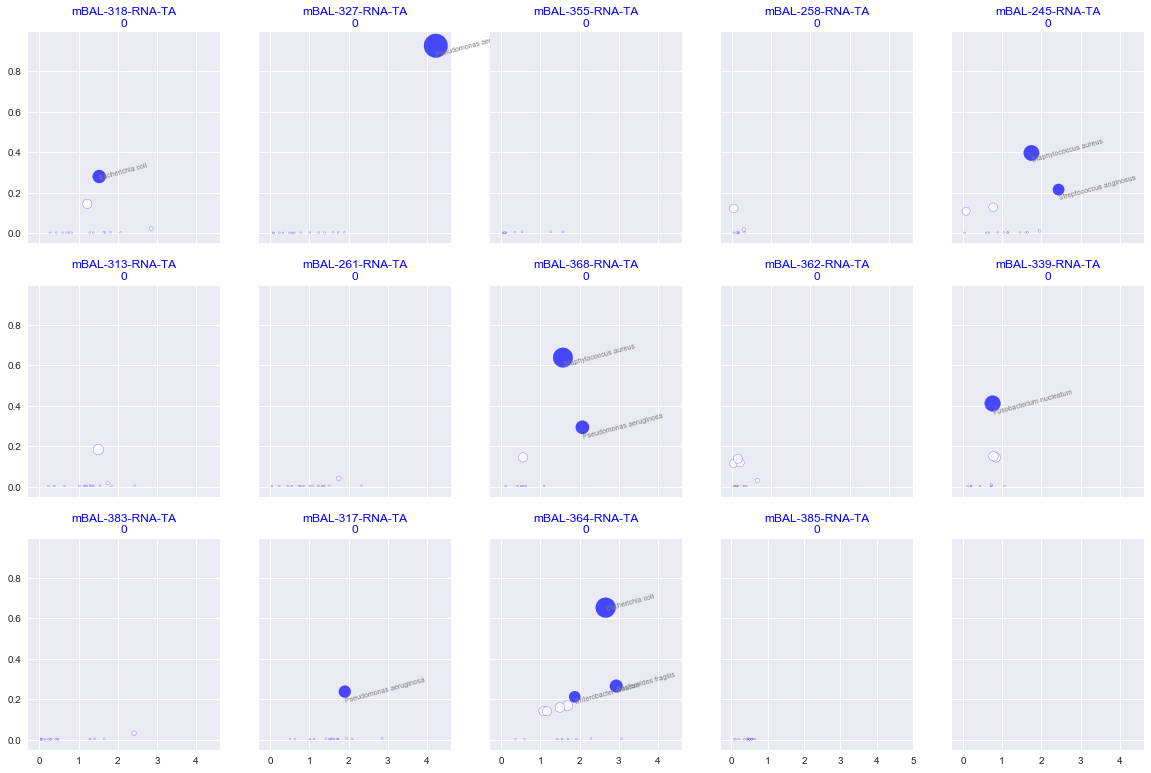

In [12]:
print("TRAINING RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots(X_g1g4_train, './output/' + output_directory + '/Investigate_Train.pdf', 4, PROBABILITY_THRESHOLD, graph_axis)

print("\nTEST RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots(X_g1g4_test, './output/' + output_directory + '/Investigate_Test.pdf', 5, PROBABILITY_THRESHOLD, graph_axis)

print("\nGROUP 2 RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots(X_g2, './output/' + output_directory + '/Investigate_G2.pdf', 7, PROBABILITY_THRESHOLD, graph_axis)

print("\nGROUP 3 RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots(X_g3, './output/' + output_directory + '/Investigate_G3.pdf', 3, PROBABILITY_THRESHOLD, graph_axis)

TEST AUC for predicting sampleIDs G1 v. G4 = 0.984375


No handles with labels found to put in legend.


Original ROC area: 0.984, [0.943 - 1.0]

At probability threshold = 0.2
TP, FP, TN, FN
(16, 3, 5, 0)


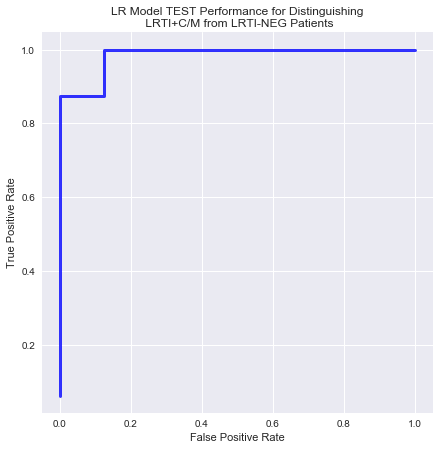

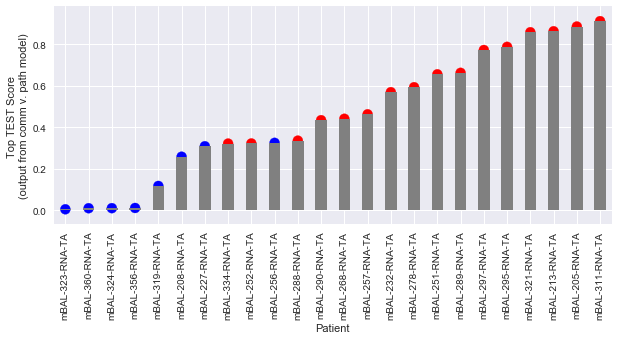

                        0  color
mBAL-323-RNA-TA  0.005624      0
mBAL-360-RNA-TA  0.010741      0
mBAL-324-RNA-TA  0.011007      0
mBAL-356-RNA-TA  0.011913      0
mBAL-319-RNA-TA  0.118068      0
mBAL-208-RNA-TA  0.259023      0
mBAL-227-RNA-TA  0.309482      0
mBAL-334-RNA-TA  0.322442      1
mBAL-252-RNA-TA  0.322955      1
mBAL-256-RNA-TA  0.325875      0
mBAL-288-RNA-TA  0.336590      1
mBAL-290-RNA-TA  0.435147      1
mBAL-268-RNA-TA  0.441894      1
mBAL-257-RNA-TA  0.463556      1
mBAL-232-RNA-TA  0.570141      1
mBAL-278-RNA-TA  0.594124      1
mBAL-251-RNA-TA  0.656373      1
mBAL-289-RNA-TA  0.663374      1
mBAL-297-RNA-TA  0.773432      1
mBAL-295-RNA-TA  0.788641      1
mBAL-321-RNA-TA  0.859199      1
mBAL-213-RNA-TA  0.863836      1
mBAL-205-RNA-TA  0.886685      1
mBAL-311-RNA-TA  0.912589      1


In [13]:
# Get the per-sampleID max score for microbe sampleID model
test_max_scores = []
test_max_truth = []
for i in set(X_g1g4_test['sampleID']):
    test_max_scores.append(
        max(X_g1g4_test[X_g1g4_test['sampleID']==i]['score']))
    test_max_truth.append(
        list(set(X_g1g4_test[X_g1g4_test['sampleID']==i]['LRTIstatus']))[0])
    
# calculate performance metrics for the test set LRTI v. no-LRTI  
fpr, tpr, thresholds = metrics.roc_curve(test_max_truth, test_max_scores, pos_label='LRTI+C+M')  
print("TEST AUC for predicting sampleIDs G1 v. G4 = " + 
      str(metrics.roc_auc_score([int(i=='LRTI+C+M') for i in test_max_truth], test_max_scores)))
IDseq_pathogen_functions2.get_CI([int(i=='LRTI+C+M') for i in test_max_truth], test_max_scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(IDseq_pathogen_functions2.perf_measure([i > PROBABILITY_THRESHOLD for i in test_max_scores], 
                                      [int(i=='LRTI+C+M') for i in test_max_truth]))


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b',
         lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model TEST Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2B.pdf')
plt.show()

# Create plot of max predicted probability score by sampleID - for visualization 
# and double-checking feasability of AUC
plt.ylabel("Top TEST Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(dict(zip(list(set(X_g1g4_test['sampleID'])),test_max_scores)),
                            orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 'LRTI+C+M') for i in test_max_truth]
df.sort_values(by=0,inplace=True)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
df[0].plot(kind='bar',color='grey',figsize=(10,4))
plt.show()

print(df)

In [14]:
# Investigating single samples
X_g1g4_test[X_g1g4_test['sampleID'] == 'mBAL-268-RNA-TA'][['sampleID','positive','genus_name','name','LRTIstatus','score']]

,sampleID,positive,genus_name,name,LRTIstatus,score
760,mBAL-268-RNA-TA,True,Pseudomonas,Pseudomonas aeruginosa,LRTI+C+M,0.441894
761,mBAL-268-RNA-TA,True,Stenotrophomonas,Stenotrophomonas maltophilia,LRTI+C+M,0.008442
762,mBAL-268-RNA-TA,False,Xylella,Xylella fastidiosa,LRTI+C+M,0.002935
763,mBAL-268-RNA-TA,False,Oryza,Oryza sativa,LRTI+C+M,0.002236
764,mBAL-268-RNA-TA,False,Pseudoxanthomonas,Pseudoxanthomonas spadix,LRTI+C+M,0.002327
765,mBAL-268-RNA-TA,False,Achromobacter,Achromobacter xylosoxidans,LRTI+C+M,0.004756
766,mBAL-268-RNA-TA,False,Non-genus-specific reads in family Xanthomonad...,[Pseudomonas] geniculata,LRTI+C+M,0.003743
767,mBAL-268-RNA-TA,False,Lysobacter,Lysobacter antibioticus,LRTI+C+M,0.002357
768,mBAL-268-RNA-TA,False,Xanthomonas,Xanthomonas fragariae,LRTI+C+M,0.011957
769,mBAL-268-RNA-TA,False,Tatlockia,Tatlockia micdadei,LRTI+C+M,0.003198
